# Behavioural Cloning Model

Plan:

1. Set up training and test sets
    - X: center image. Possibly also speed, left and right images, brake.
    - y: Steering angle
2. Normalise input data (center image)
    - Opt: Should we CV it like we did in the lane lines project?
3. Build basic Keras model.
    - Continuous output?
    - Reference traffic sign classifier model.
4. Set up evaluation of Keras model.
5. Train the model for 5 epochs and see what results we get
6. Improve on model.


In [2]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [1]:
driving_info = "data/driving_log.csv"

In [8]:
## Import data
# Added header row manually to CSV.
driving_csv = pd.read_csv("data/driving_log.csv")

In [17]:
# Examine data
print("Number of datapoints: %d" % len(driving_csv))

driving_csv.head()

Number of datapoints: 2621


,Centre Image,Left Image,Right Image,Steering Angle,Throttle,Brake,Speed
0,/Users/jessica/Downloads/behavioural-cloning/I...,/Users/jessica/Downloads/behavioural-cloning/...,/Users/jessica/Downloads/behavioural-cloning/...,0.0,0.0,0,0.419201
1,/Users/jessica/Downloads/behavioural-cloning/I...,/Users/jessica/Downloads/behavioural-cloning/...,/Users/jessica/Downloads/behavioural-cloning/...,0.0,0.0,0,0.414994
2,/Users/jessica/Downloads/behavioural-cloning/I...,/Users/jessica/Downloads/behavioural-cloning/...,/Users/jessica/Downloads/behavioural-cloning/...,0.0,0.0,0,0.410002
3,/Users/jessica/Downloads/behavioural-cloning/I...,/Users/jessica/Downloads/behavioural-cloning/...,/Users/jessica/Downloads/behavioural-cloning/...,0.0,0.0,0,0.405888
4,/Users/jessica/Downloads/behavioural-cloning/I...,/Users/jessica/Downloads/behavioural-cloning/...,/Users/jessica/Downloads/behavioural-cloning/...,0.0,0.0,0,0.001089


In [23]:
# Extract centre image and steering angle from table
# Format: X_path: centre image name, y: steeringa angle
X_path = [driving_csv.loc[i]["Centre Image"] \
              for i in range(len(driving_csv))]
y = [driving_csv.loc[i][" Steering Angle"] \
              for i in range(len(driving_csv))]

In [33]:
# Import images
# Note: Redirected X_path to this directory because previously 
# saved in a different directory
X_images = [mpimg.imread("data/" + image_path[45:]) for image_path in X_path]

Images: 2621
Sample image


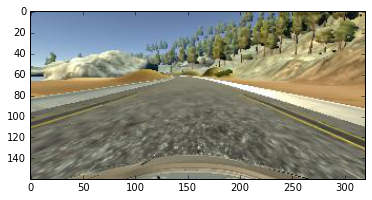

In [49]:
# View image
print("Images: %d" % len(X_images))
print("Sample image")
plt.imshow(X_images[0])
# X_images[0]

In [115]:
X_images[0].shape

(160, 320, 3)

In [50]:
# Helper functions for drawing lane lines
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

(160, 320, 3)

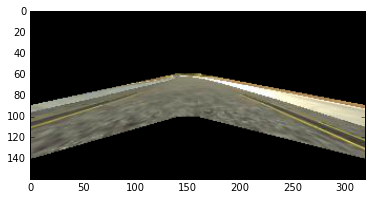

In [94]:
imshape = X_images[0].shape
vertices = np.array([[(140,100),(0,140),(0,90),(140, 60), (160, 60), (imshape[1],90),(imshape[1],140),(160,100)]], dtype=np.int32)
plt.imshow(region_of_interest(X_images[0], vertices))

In [98]:
# Process

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    print("Grayscaled image")
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    # vertices = np.array([[(0,140),(0,90),(140, 60), (160, 60), (imshape[1],90),(imshape[1],140)]], dtype=np.int32)
    vertices = np.array([[(140,100),(0,140),(0,90),(140, 60), (160, 60), (imshape[1],90),(imshape[1],140),(160,100)]], dtype=np.int32)

    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    print("BW edges image with mask")
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    print("Hough lines image")
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    return hough_rgb_image

Slope & intercept:  [[0.19254658385093168, 30.577639751552795], [0.42138364779874216, -5.4213836477987485], [0.30399999999999999, 13.024000000000001], [0.39855072463768115, -2.9420289855072497], [0.43965517241379309, -8.25]]
Slope:  0.35122722574 Intercept:  5.39764542365
Slope & intercept:  [[-0.22784810126582278, 96.911392405063296], [-0.2878787878787879, 108.62121212121212], [-0.24305555555555555, 96.243055555555557], [-0.30588235294117649, 135.36470588235295]]
Slope:  -0.26616619941 Intercept:  109.285091491
Coef:  0.35122722574 Intercept:  5.39764542365 intersection_x:  168.267820543
Point one:  (168, 64) Point two:  (960, 342)
Coef:  -0.26616619941 Intercept:  109.285091491 intersection_x:  168.267820543
Point one:  (168, 64) Point two:  (0, 109)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

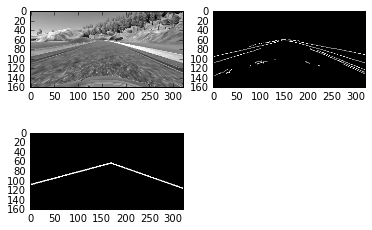

In [96]:
draw_lane_lines(X_images[0])

In [105]:
X_images_temp = X_images

In [108]:
X = []

In [110]:
X_images_temp = X_images_temp[:57] + X_images_temp[58:]

Grayscaled image
BW edges image with mask
Slope & intercept:  [[0.17499999999999999, 34.525000000000006]]
Slope & intercept:  [[-0.50657894736842102, 141.02631578947367], [-0.2857142857142857, 106.0], [-0.28676470588235292, 103.44117647058823], [-0.83333333333333337, 193.66666666666669], [-0.26890756302521007, 105.56302521008404], [-0.68055555555555558, 174.29166666666669]]
Slope:  -0.476975731813 Intercept:  137.331475134
Coef:  0.175 Intercept:  34.525 intersection_x:  157.684512042
Point one:  (157, 62) Point two:  (960, 202)
Coef:  -0.476975731813 Intercept:  137.331475134 intersection_x:  157.684512042
Point one:  (157, 62) Point two:  (0, 137)
Hough lines image
60 th image added
Grayscaled image
BW edges image with mask
Slope & intercept:  [[0.18556701030927836, 33.422680412371136], [0.21052631578947367, 24.842105263157897], [0.25, 57.5], [0.19230769230769232, 31.038461538461537]]
Slope:  0.196133672802 Intercept:  29.7677490713
Slope & intercept:  [[-0.4859154929577465, 134.4014

/Users/jessica/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/jessica/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


ValueError: cannot convert float NaN to integer

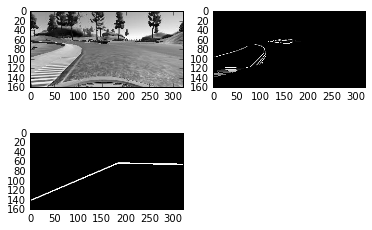

In [113]:
for i in range(60, len(X_images_temp)):
    X.append(draw_lane_lines(X_images_temp[i]))
    print("%d th image added" % i)

In [100]:
import keras

Using TensorFlow backend.


In [114]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

In [ ]:
def baseline_model():
    model = Sequential()
    # Layer 1
    model.add(Dense(512, input_shape=(160*320*3,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(Dense(1, init='normal'))
    # 

In [ ]:
# Build the deep network
# TODO: Build a two-layer feedforward neural network with Keras here.
# Sequential model is a linear stack of layers.
model = Sequential()
# Dense is a fully connnected layer
# Fully connected layer
# -> allows for non-linear combination of features 
# discovered in the previous layer
model.add(Dense(512, input_shape=(160*320*3,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# Layer 2
hidden1 = model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# Convert to 43 labels since 43 outputs
model.add(Dense(43))
# Softmax to compute probabilities
output = model.add(Activation('softmax'))

model.summary()

# STOP: Do not change the tests below. Your implementation should pass these tests.
assert(model.get_layer(name="hidden1").input_shape == (None, 32*32*3)), "The input shape is: %s" % model.get_layer(name="hidden1").input_shape
assert(model.get_layer(name="output").output_shape == (None, 43)), "The output shape is: %s" % model.get_layer(name="output").output_shape 